In [ ]:
import pandas as pd
import networkx as nx

# Load the dataset from the CSV file
file_path = '/content/Social_Network_Ads.csv'
df = pd.read_csv(file_path)

# Drop the Gender column
df = df.drop(columns=['Gender'], errors='ignore')

# Create a graph
G = nx.Graph()

# Adding nodes with attributes
for _, row in df.iterrows():
    G.add_node(row['User ID'], age=row['Age'], purchased=row['Purchased'])

# Adding edges based on age similarity (±5 years)
for i in range(len(df)):
    for j in range(i + 1, len(df)):
        if abs(df['Age'].iloc[i] - df['Age'].iloc[j]) <= 5:
            G.add_edge(df['User ID'].iloc[i], df['User ID'].iloc[j])

# Compute metrics
degree_dict = dict(G.degree())
weighted_degree_dict = {
    node: sum(G.nodes[neighbor]['age'] for neighbor in G.neighbors(node))
    for node in G.nodes
}
pagerank_dict = nx.pagerank(G)
betweenness_centrality_dict = nx.betweenness_centrality(G)

# Convert results to DataFrames
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['Degree'])
weighted_degree_df = pd.DataFrame.from_dict(weighted_degree_dict, orient='index', columns=['Weighted Degree'])
pagerank_df = pd.DataFrame.from_dict(pagerank_dict, orient='index', columns=['PageRank'])
betweenness_df = pd.DataFrame.from_dict(betweenness_centrality_dict, orient='index', columns=['Betweenness Centrality'])

# Combine all metrics into a single DataFrame
metrics_df = degree_df.join(weighted_degree_df).join(pagerank_df).join(betweenness_df)

# Reset index for better presentation
metrics_df.reset_index(inplace=True)
metrics_df.rename(columns={'index': 'User ID'}, inplace=True)

# Print the combined DataFrame
print(metrics_df.to_string(index=False))


 User ID  Degree  Weighted Degree  PageRank  Betweenness Centrality
15624510      22              478  0.006036                0.000346
15810944      29              947  0.007180                0.001263
15668575      57             1519  0.011701                0.004933
15603246      61             1657  0.012411                0.006577
15804002      22              478  0.006036                0.000346
15728773      61             1657  0.012411                0.006577
15598044      61             1657  0.012411                0.006577
15694829      49             1494  0.010536                0.004610
15600575      55             1425  0.011469                0.007561
15727311      29              947  0.007180                0.001263
15570769      57             1519  0.011701                0.004933
15606274      57             1519  0.011701                0.004933
15746139      26              577  0.006757                0.000877
15704987      49             1494  0.010536     

In [ ]:
import networkx as nx
print(nx.__version__)


3.3


In [ ]:
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())


Number of nodes: 98
Number of edges: 2095


Number of nodes: 98
Number of edges: 1058
Average degree: 21.5918


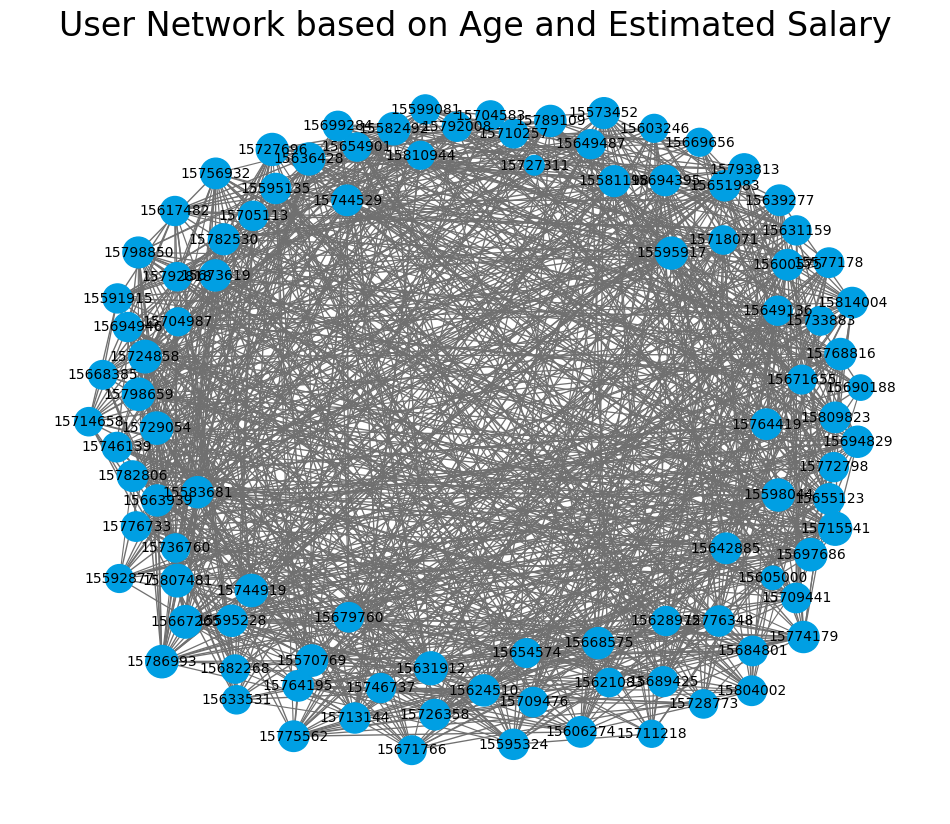

In [ ]:
import pandas as pd
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/Social_Network_Ads.csv'
df = pd.read_csv(file_path)

# Drop the Gender column
df = df.drop(columns=['Gender'], errors='ignore')

# Let's assume you want to create a feature based on 'Age' and 'EstimatedSalary'
# You can replace these with 'UsageDuration' and 'TotalLikes' as appropriate
df['Age_norm'] = (df['Age'] - df['Age'].mean()) / df['Age'].std()
df['EstimatedSalary_norm'] = (df['EstimatedSalary'] - df['EstimatedSalary'].mean()) / df['EstimatedSalary'].std()

# Create a feature matrix with Age and EstimatedSalary
feature_matrix = df[['Age_norm', 'EstimatedSalary_norm']].values

# Calculate similarity between users using cosine similarity
similarity_matrix = cosine_similarity(feature_matrix)

# Create a Graph
G = nx.Graph()

# Add edges based on similarity (use a threshold to avoid connecting everyone)
threshold = 0.8  # Only consider strong similarities
for i, user1 in enumerate(df['User ID']):
    for j, user2 in enumerate(df['User ID']):
        if i != j and similarity_matrix[i, j] > threshold:
            G.add_edge(user1, user2, weight=similarity_matrix[i, j])

# Print basic graph info manually
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# If you want to display degree statistics:
degrees = dict(G.degree())
print(f"Average degree: {sum(degrees.values()) / len(degrees):.4f}")

# Subgraph for users with more than a certain number of connections
subG = G.subgraph([n for n in G.nodes if G.degree(n) > 2])

# Draw the subnetwork
pos = nx.spring_layout(subG, weight='weight', iterations=20, k=4)

plt.figure(figsize=(12, 10))
plt.axis('off')
plt.title('User Network based on Age and Estimated Salary', fontsize=24)

# Draw nodes
node_sizes = [100 * G.degree(node) ** 0.5 for node in subG.nodes()]
nx.draw_networkx_nodes(subG, pos, node_size=node_sizes, node_color='#009fe3')

# Draw edges with varying widths based on weight
for e in subG.edges(data=True):
    nx.draw_networkx_edges(subG, pos, edgelist=[e], width=e[2]['weight'] * 1, edge_color='#707070')

# Add labels
nx.draw_networkx_labels(subG, pos, font_size=10)

# Show plot
plt.show()
